# Working with an Organization-Wide Dependency Graph

Version 2.4.1 of the ArcGIS API for Python brought about some exciting new functionality for content management: the `arcgis.apps.itemgraph` module. This module, in it's most basic usage, allows you to take an item in an organization and examine the deep dependencies of it- what items it needs to exist, what items those items need to exist, and so on. This is very helpful for management of apps and smaller subsets of org items, but what if we really want to push the limits of what we can do with this module?

With a little patience and creativity, we can create an actively-updated dependency graph that encapsulates every item in our organization. Doing so opens up all sorts of doors for us, such as:
- The ability to examine the total reverse dependencies of an item (e.g., take a feature layer- we can see every app or map in our org that requires it to exist, or that will be effected by a change to it
- Quick identification of all broken dependencies in our organization
- Sorting of org items by complexity (most vs. least dependencies)

In this sample, we'll provide code to create and update an organization-wide graph, glean information from our graph, and then finally include a section on how to automate this process via ArcGIS Notebooks.

## Part 1: Creating and Updating an Org-Wide Graph

In [2]:
from arcgis.gis import GIS
from arcgis.apps.itemgraph import create_dependency_graph, load_from_file
import datetime
import networkx as nx
gis = GIS("home")

### Initial Run

This builds the initial dependency graph by indexing over every single item in the organization. This only needs to be run once, and will likely take a very long time, depending on how many items are in the org. Once it's been run and the graph structure and time stamp are saved into files, this notebook that updates the dependency graph can be run. This first cell can also be executed outside of ArcGIS Notebooks, and the .gml and .txt files can be brought in from elsewhere.

*Note: Comment out this cell after the first time running the notebook.*

In [3]:
# only run this cell the very first time you index over your org and grab all the dependencies
# this will take a long time if the org has a ton of items

import datetime
items = gis.content.search("", max_items = 10000)
timestamp = int(datetime.datetime.now().timestamp()) * 1000
graph = create_dependency_graph(gis, items)
graph.write_to_file("/arcgis/home/graph_data/updating_graph.gml")
with open("/arcgis/home/graph_data/updating_timestamp.txt", "w") as file:
    file.write(str(timestamp))

Now, we have a snapshot of every item in the organization and how they relate to one another. But, what if we don't want to run this lengthy initial step every time we want to work with this graph? And what if there are items that are getting created, updated, and deleted, so the relationships in this graph might become outdated? This notebook will go over how we can use specific capabilities of the ItemGraph to examine massive graphs without re-indexing, and will include code that will update the graph through automation, meaning that scheduling this notebook to run will ensure that your organization-wide dependency graph stays up to date.

### Efficiently Analyzing the Existent Graph

When loading up an existent graph based on a .gml file, it still may take some time to retrieve every single item associated with each node in the graph, especially for organizations with thousands and thousands of items. If you want to instantly analyze the items and relationships in a .gml file with thousands of records, we can call `load_to_file()` and elect to *not* retrieve each item. This still gives us the power to view all item id's and their dependencies in the org, but without the overhead of retrieving each one from a REST endpoint first. Users can simply retrieve the associated items as needed, based on the id's.

We'll show a quick example of this using the existent graph, and then use a graph loaded with the items to ensure we're up-to-date with the current state of organization. We'll only print the first few for the sake of keeping this page short.

In [101]:
fast_graph = load_from_file("/arcgis/home/graph_data/updating_graph.gml", gis, False)
len(fast_graph.all_items())

3643

In [103]:
fast_graph.all_items()[:20]

[ItemNode(id: 72c2671bff1143c4bc577755bc00a7aa),
 ItemNode(id: 405b512903e74ec0af5ce2083b863705),
 ItemNode(id: 039e2c7e648b4a5d9d64c57b470d7397),
 ItemNode(id: 64a096654b924b2998ed07a747524e96),
 ItemNode(id: e12e8599965c43af9632a5c9633c2994),
 ItemNode(id: 5b534fa4a26d4fd1868ea7509806b053),
 ItemNode(id: 96cf6c756ee74c288a8a88788f980266),
 ItemNode(id: 64480b5bfc474ab1a464fa18098c92e5),
 ItemNode(id: 14d12cc813b2422db0f4b7b1b701bcc1),
 ItemNode(id: 5a1a8ac568a942b792c1283b7acff602),
 ItemNode(id: dc5014dff7014a23af6eff25b492bce6),
 ItemNode(id: 1fcbf4e77ebc46ef9971d1194f412c3b),
 ItemNode(id: fc02404cdda24f72842d34b28267d77a),
 ItemNode(id: 4cc1488a3c134af9abbe0a268d50b499),
 ItemNode(id: 24ca75398c494dad8b4e7104e2a640d5),
 ItemNode(id: 4839158f96544bafb841c1739d84f11b),
 ItemNode(id: 9b9de0ff974e4924b15bc278ad6d6676),
 ItemNode(id: 87c2394212ad42bcb89de9e244d4072d),
 ItemNode(id: 13697d5ab62449e78dd9c28037380592),
 ItemNode(id: a93fd45749ec4773839f02623ebad01d)]

<Item title:"Latin America" type:Mobile Map Package owner:esri_nav>
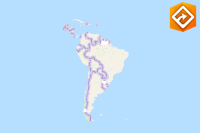

In [5]:
random_node = fast_graph.all_items()[0]
gis.content.get(random_node.id)

As we can see, we can instantly load in this complicated graph and just grab the `Item` associated with a given node as needed. However, for this next part, we're going to need to retrieve everything in the graph, which could take a while; that's why it's meant for some scheduled automation.

### Automation: Updating our Org-Wide Graph

The items in our org might not be the same as the ones we had in it yesterday- that's why we want to update our graph periodically. We can use some attributes of the `ItemGraph` class and some networkx tricks to maintain an up-to-date record of everything in the org.

We'll start by loading up our existent graph stored in the .gml file with every `Item` attached. This may take a while to do, depending on how many items must be retrieved. We retrieve the items so that later we can verify which ones still exist and which ones have been deleted.

In [6]:
# grab the graph created yesterday to update it
old_graph = load_from_file("/arcgis/home/graph_data/updating_graph.gml", gis, True)

Keeping timestamps allows us to understand when the last time we updated the graph was and maintain an accurate graph. This approach allows for the scheduling of this notebook on any timeframe- whether you run it every day, every week, every month, or something else.

In [7]:
# grab our old and new timestamps
# old is the last time we updated the graph, new is current time
with open("/arcgis/home/graph_data/updating_timestamp.txt", "r") as file:
    old_timestamp = int(file.read())
new_timestamp = int(datetime.datetime.now().timestamp()) * 1000

# use these timestamps to see items that have been modified or created since last run
q = f"modified: [{old_timestamp} TO {new_timestamp}]"
modified_items = gis.content.search(query = q, sort_field = "modified", sort_order = "desc")

In [8]:
# now that we have our list of updated items, make a graph out of them
mod_graph = create_dependency_graph(gis, modified_items)

Now we have a graph containing only new/modified items, and all of their dependencies. We'll have to combine the new information in this graph with our existent graph, and delete the outdated information. Time for some fun graph operations!

In [10]:
# nx.compose() combines all nodes and relationships of two graphs
new_graph = nx.compose(old_graph, mod_graph)

# find the list of items in both graphs
# these are ones that already existed but were modified, meaning dependencies might have changed
intersects = set(old_graph.all_items('id')) & set(mod_graph.all_items('id'))

# go through these items and delete outdated forward dependencies
for itemid in list(intersects):
    old_contains = set(old_graph.get_node(itemid).contains("id"))
    mod_contains = set(mod_graph.get_node(itemid).contains("id"))
    
    # isolate deps that only existed in old graph
    outdated = old_contains - mod_contains

    # remove these relationships from the new graph
    for dep in list(outdated):
        new_graph.delete_relationship(itemid, dep)

Our `new_graph` now has an accurate reflection of all item relationships in our organization- any item that got changed could have had it's forward dependencies altered, so we made sure that those got updated to reflect any changes. We didn't have to worry about changing any reverse dependencies, since every reverse dependency is still just a forward dependency for another item, so the appropriate relationship was addressed during that process.

We have one more little housekeeping thing to do with this new graph now- due to the way that `nx.compose()` works, the individual nodes within the new graph still contain references to the old graph. We just have to make sure those nodes now use the new graph for any computation.

In [11]:
# make sure our nodes are all referencing the new updated graph
for node in new_graph.all_items():
    node.graph = new_graph

Alright, awesome, now we have all newly created or recently modified items accounted for- but we still have to account for items that might have been deleted. How do we do this? 

Remember when we ran the `load_from_file()` function earlier that retrieved all of the items while rebuilding the graph? Well, any node of an item that's been deleted won't have an attached `Item` object anymore, since it wouldn't have been retrieved. Therefore, if we have a node with no associated item, we can assume the item has been deleted, and that if the node is not contained by another node, then the item is not still meant to exist. So, we can delete nodes from our graph that fit that criteria.

One added layer of complexity: what if the node of a deleted item is contained by another node of a deleted item that just hasn't been processed yet? We can avoid this scenario by sorting our nodes in ascending order of how many items they're required by, ensuring we're prioritizing processing ones furthest up the dependency chains first (e.g., deleted item A contains B which contains C- if we analyze B or C first, we'll wrongfully keep them, but if we start with A and go down the chain, all will get deleted properly).

In [12]:
nodes = new_graph.all_items()

# define our sort function
def count_reqs(node):
    return len(node.required_by("id"))

# this orders our nodes properly
sorted_nodes = sorted(nodes, key=count_reqs)

# remove ones that don't have items and aren't dependencies of others
for node in sorted_nodes:
    if not node.item and not node.contained_by():
        new_graph.remove_node(node.id)

And there we have it. Now we have a properly updated graph, one that reflects today's state of every item and their dependencies. Grabbing a node for a given item from `new_graph` should give you a holistic look of all items it relates to in an org, no matter if it's an immediate or deep relationship in either direction. To summarize, we:

- Loaded in the graph from the last time we ran the notebook
- Determined what items had been modified/created since the last time we ran the notebook
- Created a graph from those updated items, capturing their current dependencies
- Merged the old graph with the modified graph to create a new graph with all nodes/relationships from both graphs
- Got rid of relationships that no longer existed from the new graph
- Got rid of any items that had been deleted and weren't dependencies of an item from the new graph

Now, we'll write out the state of this graph and the timestamp at which we started everything, so we can repeat this process in the future and continue to update our graph as the items in our ArcGIS organization evolve.

In [14]:
new_graph.write_to_file("/arcgis/home/graph_data/updating_graph.gml")
with open("/arcgis/home/graph_data/updating_timestamp.txt", "w") as file:
    file.write(str(timestamp))

## Part 2: Using the Graph

Now that we have our organization-wide graph and know that it's up to date, we can use it for some useful administration and analysis. We'll take a look at the three things mentioned in the intro: examining comprehensive reverse dependencies of items, identifying broken dependencies that need fixing, and sorting our items based on their complexity.

### Comprehensive Reverse Dependencies

This is a very powerful perk of having every relationship in an organization included in a graph: the ability to see _every_ single item that relies on a specific item. Say you have a feature layer that is used in numerous maps and applications throughout your org: you can instantly acquire a list of every one that consumes it, either directly or indirectly. Let's take a look.

In [31]:
# grab a node corresponding to a feature layer
flayer_id = "7dc6cea0b1764a1f9af2e679f642f0f5"
flayer_node = new_graph.get_node(flayer_id)
flayer_node.item

<Item title:"World Topographic Map" type:Vector Tile Layer owner:esri_livingatlas>

Calling `.contained_by()` will show all of the items that contain our vector tile layer.

In [34]:
flayer_node.contained_by("item")

[<Item title:"National Day1 - With Created Layer" type:Web Map owner:arcgis_python>,
 <Item title:"National Day1 - With Created Layer" type:Web Map owner:arcgis_python>,
 <Item title:"AZ and NM Cities" type:Web Map owner:nparavicini>,
 <Item title:"Topographic" type:Web Map owner:nparavicini>,
 <Item title:"Living Atlas Map" type:Web Map owner:nparavicini>,
 <Item title:"Capital Map" type:Web Map owner:nparavicini>,
 <Item title:"New York Enriched Top Areas of Interest" type:Web Map owner:arcgispyapibot>,
 <Item title:"New York Enriched Top Areas of Interest" type:Web Map owner:arcgispyapibot>]

Calling `.required_by()` will show us all of the items that depend on our layer in some way.

In [35]:
flayer_node.required_by("item")

[<Item title:"All About Arizona and New Mexico" type:StoryMap owner:nparavicini>,
 <Item title:"National Day1 - With Created Layer" type:Web Map owner:arcgis_python>,
 <Item title:"Living Atlas Map" type:Web Map owner:nparavicini>,
 <Item title:"Ruff Ruff" type:StoryMap owner:nparavicini>,
 <Item title:"Capital Map" type:Web Map owner:nparavicini>,
 <Item title:"New York Enriched Top Areas of Interest" type:Web Map owner:arcgispyapibot>,
 <Item title:"Topographic" type:Web Map owner:nparavicini>,
 <Item title:"AZ and NM Cities" type:Web Map owner:nparavicini>,
 <Item title:"National Day1 - With Created Layer" type:Web Map owner:arcgis_python>,
 <Item title:"Copy this story" type:StoryMap owner:arcgis_python>,
 <Item title:"New York Enriched Top Areas of Interest" type:Web Map owner:arcgispyapibot>,
 <Item title:"San Diego Parrot Sightings" type:Form owner:nparavicini>,
 <Item title:"Testing Copy Content" type:StoryMap owner:arcgispyapibot>]

There we have it- we instantly determined which items would be affected by deleting or changing our layer.

### Finding Broken Dependencies

In this context, we're calling an item that is contained by another item, but isn't valid or accessible, a "broken" dependency- these sorts of items can lead to rendering or logic issues in applications such as Web Maps, StoryMaps, Experiences, Surveys, and so on. There can be a number of reasons for why these improper dependencies may exist- an item being used by an application mistakenly got deleted, there was some sort of corruption with data, the json structure of an application might have been copied from one in a different org, and so on.

Luckily, the way the `ItemGraph` is constructed allows us to instantly find these cases where something is potentially awry. During construction of the graph, the ID of each `ItemNode` was passed into the GIS org to see if it yielded an item. Therefore, any node that doesn't have an `.item` property could potentially be a problem.

In [36]:
no_item_nodes = [node for node in new_graph.all_items() if not node.item]
no_item_nodes

[ItemNode(id: 370b95fdf676475ca8fd184ad0931610),
 ItemNode(id: 1dc6042bb3ba409c9d1eb1d7c996d6ed),
 ItemNode(id: bf08d46ab087435aa4afbc62092223cb),
 ItemNode(id: 123hehethiswontwork),
 ItemNode(id: 2fe20a161c514e16b805a21a7e2d636b),
 ItemNode(id: 15efb8c0d9e3447782789592f432fc1a),
 ItemNode(id: bda2f1dc3c824c3e97f4a682554177cf),
 ItemNode(id: bbf4d26d7c3340dab009c7164cc3e1e5),
 ItemNode(id: d60affb34dd948a1b973da076830ad00),
 ItemNode(id: 1182ef6f62a543fdba4a55c85c014431),
 ItemNode(id: f32924d7b16f41d78839dba3b943b08c),
 ItemNode(id: 9f91d4c34f194da793c8573b24a751a9),
 ItemNode(id: 91fa101048bb4855970f7d004a4542ce),
 ItemNode(id: 6e02b538bea841ed858ef9f52709b655),
 ItemNode(id: 878802f78aad4ab5a83c1397c72048c5),
 ItemNode(id: f1801a1b3d674de7b9de246a126eb17b),
 ItemNode(id: 2),
 ItemNode(id: 44c3348139a84423b4a46074a104efdf),
 ItemNode(id: 74ab88e7e22d4dbd93b43a00b2d0155b),
 ItemNode(id: 306cf223a2fd46d3bf6ce39225681977),
 ItemNode(id: 1ee3200825ce448c91a1ec9ae4f70c28),
 ItemNode(id: 7

As we can see, we now have a list of nodes where the ID's don't lead to a portal item. There is one anomaly here: what appears to be a service that just doesn't have an associated portal item, but still may be valid. We can add some separate logic to ensure we test any URL for valid data.

In [83]:
from arcgis.layers import Service
updated_no_item = []
for node in no_item_nodes:
    if "https://" in node.id:
        try:
            serv = Service(node.id)
            if not serv:
                raise
        except:
            updated_no_item.append(node)
    else:
        updated_no_item.append(node)

Given this list of items with ID's that lead nowhere, we can grab the node for any one of them and do what we did above- see which org items contain or require them. From there, we can figure out how to fix it- one option is using the `remap_data()` function, documented [here](https://developers.arcgis.com/python/latest/api-reference/arcgis.gis.toc.html#arcgis.gis.Item.remap_data).

In [39]:
broken_node = updated_no_item[0]
broken_node.contained_by()

[ItemNode(id: e6430fd93abe46ccaf2a8e31b5a35c80, item: AZ Vehicle Incidents)]

In [40]:
broken_node.required_by()

[ItemNode(id: e6430fd93abe46ccaf2a8e31b5a35c80, item: AZ Vehicle Incidents),
 ItemNode(id: d3b24b91f2c3432fbb5b7d2862f7525d, item: TestInstantApp),
 ItemNode(id: 7259119a69044ae4aebd3e4cd338321f, item: AZ Vehicle App)]

### Sorting Items by Degree, Type, and More

Finally, let's put ourselves in the shoes of an organization admin that wants to learn about the items in their org: which items have the most dependencies, and which ones are needed by the most items? Which ones have the most broken dependencies? Let's take a look at how we can capitalize on some graph logic and networkx tricks to gain insights into our organization's content.

We'll start basic: just identify which nodes have the highest _degree_, or number of direct relationships ("contains"/"contained by"). Since a degree can refer to either direction relationship, we specify the _out_ degree or _in_ degree, which in an `ItemGraph` will show the amount of each node's `contains()` and `contained_by()`, respectively.

In [93]:
def sort_degrees(direction = "out", descending = True, result_count = 50):
    node_degrees = new_graph.out_degree()
    if direction == "in":
        node_degrees = new_graph.in_degree()
    nodes_sorted = sorted(node_degrees, key=lambda item: item[1], reverse=descending)
    if result_count and result_count > len(nodes_sorted):
        result_count = len(nodes_sorted)
    for node, degree in nodes_sorted[:result_count]:
        graph_node = new_graph.get_node(node)
        if graph_node.item:
            print(f"Title: {graph_node.item.title}, Type: {graph_node.item.type}, Degree: {degree}")
        else:
            print(f"ID: {node}, Degree: {degree}")

In [94]:
# find which items contain the most other items
sort_degrees(direction = "out", descending = True, result_count = 50)

Title: New York Enriched Top Areas of Interest, Type: Web Map, Degree: 158
Title: New York Enriched Top Areas of Interest, Type: Web Map, Degree: 158
Title: DevTechSummit2025-copy-1745540837450, Type: Hub Site Application, Degree: 13
Title: My Site in Enterprise - new, Type: Hub Site Application, Degree: 12
Title: San Diego Parrot Sightings, Type: Form, Degree: 6
Title: Discover Green Spaces and Wildlife in Berlin, Type: Web Mapping Application, Degree: 6
Title: AZ Vehicle Incidents, Type: Web Map, Degree: 4
Title: Living Atlas Map, Type: Web Map, Degree: 4
Title: SimpleWebMap, Type: Web Map, Degree: 4
Title: Arkansas Hospitals, Type: Web Map, Degree: 4
Title: TestInstantApp, Type: Web Mapping Application, Degree: 3
Title: map test, Type: Web Map, Degree: 3
Title: Cycling Explorer, Type: Web Map, Degree: 3
Title: AZ and NM Cities, Type: Web Map, Degree: 3
Title: Jy Survey 123 Connect, Type: Form, Degree: 3
Title: Jy Survey 123 Connect, Type: Form, Degree: 3
Title: map test, Type: Web M

In [96]:
# find which items are contained by the most other items
sort_degrees(direction = "in", descending = True, result_count = 50)

ID: bf08d46ab087435aa4afbc62092223cb, Degree: 153
ID: 123hehethiswontwork, Degree: 153
ID: 7f7c4245f03445e782e9aa4a4d06221d, Degree: 33
ID: 07a05ca8a10843aba797076d40ca8f36, Degree: 33
Title: World Topographic Map, Type: Vector Tile Service, Degree: 8
Title: Web Map 400800, Type: Web Map, Degree: 7
Title: Outline Map, Type: Web Map, Degree: 7
Title: Newspaper (WGS84), Type: Vector Tile Service, Degree: 5
Title: OpenStreetMap Streets with Relief, Type: Vector Tile Service, Degree: 5
ID: 2, Degree: 3
Title: Esri_Regional_Offices_US, Type: File Geodatabase, Degree: 3
Title: Jy Survey 123 Connect, Type: Feature Service, Degree: 3
Title: Jy Survey 123 Connect, Type: Feature Service, Degree: 3
Title: AZ Vehicle Incidents, Type: Web Map, Degree: 2
Title: Basic, Type: Web Mapping Application, Degree: 2
Title: AGO World Geocoder (arcgis_python), Type: Geocoding Service, Degree: 2
ID: 2fe20a161c514e16b805a21a7e2d636b, Degree: 2
ID: 15efb8c0d9e3447782789592f432fc1a, Degree: 2
ID: bda2f1dc3c824c3e

We can similarly define a function that will do that for the "deep" degrees- finding which items have the most recursive dependencies or items dependent upon them.

In [97]:
def sort_deep_degrees(direction = "out", descending = True, result_count = 50):
    if direction == "in":
        nodes_weighted = [(node, len(node.required_by())) for node in new_graph.all_items()]
    else:
        nodes_weighted = [(node, len(node.requires())) for node in new_graph.all_items()]
    nodes_sorted = sorted(nodes_weighted, key=lambda item: item[1], reverse = descending)
    if result_count and result_count > len(nodes_sorted):
        result_count = len(nodes_sorted)
    for node, degree in nodes_sorted[:result_count]:
        if node.item:
            print(f"Title: {node.item.title}, Type: {node.item.type}, Degree: {degree}")
        else:
            print(f"ID: {node.id}, Degree: {degree}")

In [98]:
sort_deep_degrees()

Title: Testing Copy Content, Type: StoryMap, Degree: 159
Title: New York Enriched Top Areas of Interest, Type: Web Map, Degree: 158
Title: New York Enriched Top Areas of Interest, Type: Web Map, Degree: 158
Title: DS-Page1-copy-1745540879568, Type: Hub Page, Degree: 14
Title: DevTechSummit2025-copy-1745540837450, Type: Hub Site Application, Degree: 13
Title: My Site in Enterprise - new, Type: Hub Site Application, Degree: 12
Title: TestInstantApp, Type: Web Mapping Application, Degree: 8
Title: San Diego Parrot Sightings, Type: Form, Degree: 8
Title: All About Arizona and New Mexico, Type: StoryMap, Degree: 8
Title: AZ Vehicle App, Type: Web Mapping Application, Degree: 8
Title: Discover Green Spaces and Wildlife in Berlin, Type: Web Mapping Application, Degree: 7
Title: Formerly Local, Now Global Experience, Type: Web Experience, Degree: 6
Title: AZ Vehicle Incidents, Type: Web Map, Degree: 5
Title: AZ and NM Cities, Type: Web Map, Degree: 5
Title: Ruff Ruff, Type: StoryMap, Degree: 5

Finally, we can construct a custom function that can do the two prior bits, plus sort items by type, and define the result count. This allows us to easily filter and search  our org's items with additional context on the weight of their dependencies.

In [85]:
def filter_nodes(direction = "out", deep = False, descending = True, item_type = None, result_count: int = None):
    if item_type:
        nodes_filtered = [node for node in new_graph.all_items() if node.item and node.item.type == item_type]
    else:
        nodes_filtered = new_graph.all_items()
    if direction == "in" and deep:
        nodes_weighted = [(node, len(node.required_by())) for node in nodes_filtered]
    elif direction == "out" and deep:
        nodes_weighted = [(node, len(node.requires())) for node in nodes_filtered]
    elif direction == "in" and not deep:
        nodes_weighted = [(node, len(node.contained_by())) for node in nodes_filtered]
    else:
        nodes_weighted = [(node, len(node.contains())) for node in nodes_filtered]
    nodes_sorted = sorted(nodes_weighted, key=lambda item: item[1], reverse = descending)
    if result_count and result_count > len(nodes_sorted):
        result_count = len(nodes_sorted)
    for node, degree in nodes_sorted[:result_count]:
        if node.item:
            print(f"Title: {node.item.title}, Type: {node.item.type}, Degree: {degree}")
        else:
            print(f"ID: {node.id}, Degree: {degree}")

## Part 3: Automating this Notebook

Everything we've done in this notebook is purely informative- no changes, additions, or deletions to org items were done. All we've done is update and manipulate or ItemGraph in memory and written out to file. So what does this mean? 

This means that you can download this very notebook and run it for yourself. Keeping this notebook run on a consistent timeframe will provide you with an up-to-date graph to analyze your org items. ArcGIS Notebooks, in both ArcGIS Online and ArcGIS Enteprise, provide us with an easy way to schedule automation of notebooks. Let's take a look how.

### Scheduling a Task

A "task" is a command to run a given notebook. You can create scheduled tasks that dictate when and how often to run a notebook. Each time the notebook is run according to the schedule you set, the site opens a new container and runs the notebook without user control.

To access this function, open the "Tasks" pane in the notebook editor. You can schedule it to run just once in the future or on a recurring basis— from once every 15 minutes to once every 6 months.

Once you click on the Tasks pane, you will be prompted to provide a title for the Task.

![Image](https://github.com/user-attachments/assets/0e374e87-e08d-4789-9cb8-e6a387ac18f6)

You can also set other specific parameters for when and how often you would like for this notebook to run.

![parameters](https://github.com/user-attachments/assets/551a68f5-976a-47ea-83c1-257c99643ffd)

Once you have created this task, you can find it under the Tasks pane, and can pause, delete or edit it as necessary. 

![tasks](https://github.com/user-attachments/assets/975a6137-1cf7-4e6c-ae1c-85342b534d7f)

> Note: For Notebooks in ArcGIS Online, you can have a maximum of 10 active tasks across all your notebooks. If you pause some of your active tasks, you will be allowed to create more tasks until you reach 10 active tasks again. For Notebooks in ArcGIS Enterprise, the default number of maximum active tasks is set at 20. Administrators of an organization have the privilege to [change that limit](https://developers.arcgis.com/rest/enterprise-administration/portal/limits-system). 